# ⚡️ Activate Virtual Environment

Prepare the virtual environment in which we will conduct our experiement. 

In [5]:
!python -m venv env_journal_entries_mixtral
!source env_journal_entries_mixtral/bin/activate # For Unix or MacOS
# !myenv\Scripts\activate # For Windows

SyntaxError: invalid syntax (2794603235.py, line 5)

## ⬇️ Install Dependencies

In [142]:
# Freeze all pip packages into a requirements.txt file to preserve the environment
# Only run this command when you have installed a new package
!pip freeze > requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
!pip install -r requirements.txt

  Cloning https://github.com/huggingface/accelerate.git (to revision 6719cb6db31f57ea5d2fdb179b0487f51718f353) to /private/var/folders/v9/kls8l3fd0sb1gk104l1y05sh0000gn/T/pip-install-qhg7s_dh/accelerate_8b6c5c580d524d168fc47b284eb6111b
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /private/var/folders/v9/kls8l3fd0sb1gk104l1y05sh0000gn/T/pip-install-qhg7s_dh/accelerate_8b6c5c580d524d168fc47b284eb6111b
  Running command git rev-parse -q --verify 'sha^6719cb6db31f57ea5d2fdb179b0487f51718f353'
  Running command git fetch -q https://github.com/huggingface/accelerate.git 6719cb6db31f57ea5d2fdb179b0487f51718f353
  Running command git checkout -q 6719cb6db31f57ea5d2fdb179b0487f51718f353
  Resolved https://github.com/huggingface/accelerate.git to commit 6719cb6db31f57ea5d2fdb179b0487f51718f353
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning http

# 🤖 Load Base Model

- Load the base model using the transformers library
- Use 4-bit quant for a good tradeoff between model performance and memory costs

In [21]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "TheBloke/dolphin-2.5-mixtral-8x7b-GGUF"

# UNCOMMENT BELOW TO LOAD MODEL
# -----------------------------
# nf4_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    quantization_config=nf4_config, 
    device_map="auto",
    use_cache=False,
    attention_implementation="flash_attention_2"
)

# Set the device to GPU (if available)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

### 🌓 Some differences from Harper's tutorial

`use_cache=False`  
- **Purpose**: Prevents storing the outputs of the attention layers.

- **Why Use It**: Reduces memory usage, which is beneficial when only the final model output is needed, not the intermediate states.


`attention_implementation="flash_attention_2"`  
- **Purpose**: Specifies a particular implementation of the attention mechanism.

- **Why Use It**: Improves performance and efficiency, potentially enhancing speed and reducing resource consumption. Useful in scenarios demanding high computational efficiency.

# 🔠 Tokenization

- Language models, especially transformer-based ones like BERT or GPT, understand and process text in terms of tokens, not words
- For this reason, it's more accurate to segment entries based on token count rather than word count, which we will do later on in **Data Preparation**
- Think about inputs and outputs to and from the model as tokens, which are embeddings that allow the model to understand our language

In [139]:
from transformers import AutoTokenizer

tokenizer_model_id = "mistralai/Mixtral-8x7B-v0.1"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_id)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
tokenizer.add_eos_token = True
tokenizer.add_bos_token = True

## 🔳 Let's Talk About Padding

We set the tokenizer's padding to the left side with the line 

```python
tokenizer.padding_side = "left"
```

### 🤔 Why do we add padding?

- Neural networks require inputs of the same size for processing in batches

- Sequences like sentences have different lengths

- To process these sequences, they're converted into a matrix

- Padding adjusts shorter sequences to match the longest one in the batch

- Uniform-sized matrices are essential for efficient computation in neural networks



### 🔄 Possible Adjustments in Tokenizer Configuration

**EOS and BOS Tokens**: 

- `tokenizer.add_eos_token = True` and `tokenizer.add_bos_token = True` are set to automatically append end-of-sequence (EOS) and beginning-of-sequence (BOS) tokens. This is crucial if the model's training expects every input sequence to start with a BOS token and end with an EOS token.

- Make sure these settings align with how the model was pre-trained. Misalignment can affect the model's understanding of sequences.

### 🚩 Important Points to Remember

**Padding Tokens and Model Processing**:

- Padding tokens are generally ignored during training and evaluation. This is achieved through a process called masking, ensuring these tokens don't influence the model's learning or predictions.

- It's important to understand why `tokenizer.pad_token = tokenizer.eos_token`. In some models, the padding token is expected to be the same as the EOS token, but this depends on the model's original training setup.

### 🧭 Padding Side: Left vs. Right

**Choosing the Padding Side**:
- The decision between left and right padding hinges on the model architecture and its sequence processing direction.

- For models like GPT, which process sequences from left to right, right padding is usually preferred. This way


### 🗣️ Generate Model Response

✋🏽 Make sure to cross-check generate_response with how it is done in Harper's tutorial 

In [140]:
# ✋🏽 Make sure to cross-check generate_response with how it is done in Harper's tutorial 
def generate_response(prompt, model):
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
    model_inputs = encoded_input.to("cuda")

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=512,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id)

    decoded_output = tokenizer.batch_decode(generated_ids)

    return decoded_output[0].replace(prompt, "")

# 🧩 Data Preparation

### 🚀 Goal
Transform the journal entry data into a format we can use for training

In [2]:
import json
from scripts.prepare_journals_for_training import process_files

# Format each entry in journal_entries as {"date": "2022-05-12", "note": "This is a journal entry."}
journal_entries = process_files('data/raw/journal_entries/')

# Save formatted entries to a JSONL file
with open('data/processed/journal_entries.jsonl', 'w') as outfile:
    for entry in journal_entries:
        json.dump(entry, outfile)
        outfile.write('\n')

### ✔️ Goal complete?

Is the journal entry data in a format we can use for training?  

Yes! Each journal is in a format from which the important parts can be plcuked, i.e. `date` and `note`.

The journal entries are now processed and in a single `.jsonl` file that looks like this:  
```json
{"date": "2022-05-12", "note": "This is a journal entry."}
{"date": "2022-05-13", "note": "This is a journal entry."}
{"date": "2022-05-14", "note": "This is a journal entry."}
```

## Data Quality Check
✅ Load journal entries from a JSONL file into a pandas DataFrame.  
✅ Display the first few rows of the DataFrame for an initial glance at the data.  
✅ Identify and report any missing values in key columns like date and note.  
✅ Ensure all date entries are in the correct Timestamp format.  
✅ Verify that all journal entries are formatted as strings.  

In [3]:
import pandas as pd

df = pd.read_json('data/processed/journal_entries.jsonl', lines=True)
print("DF Head\n", df.head(), "\n")

# Check for missing values in both date and note columns
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Validate Date Format - if the dates are already in Timestamp format, they are valid
invalid_dates = df[~df['date'].apply(lambda x: isinstance(x, pd.Timestamp))]
print("\nInvalid dates found:\n", invalid_dates)

# Check Journal Entry Format
# Ensure that all journal entries are strings
non_string_entries = df[~df['note'].apply(lambda x: isinstance(x, str))]
print("\nNon-string entries found:\n", non_string_entries)

# Data Consistency and Completeness
# Look for any anomalies in data, such as extremely short or long entries, or entries with unusual characters
print("\nStatistics for 'note' lengths:\n", df['note'].str.len().describe())


DF Head
         date                                               note
0 2021-12-30  A porn addiction\nPoor performance at work\nNo...
1 2022-03-27  You raped my childhood if any innocence it eve...
2 2022-12-07                                                   
3 2024-01-07  I have to admite something. Although i am sad ...
4 2021-12-20                                                    

Missing values in each column:
 date    0
note    0
dtype: int64

Invalid dates found:
 Empty DataFrame
Columns: [date, note]
Index: []

Non-string entries found:
 Empty DataFrame
Columns: [date, note]
Index: []

Statistics for 'note' lengths:
 count      702.000000
mean      2221.309117
std       3101.092724
min          0.000000
25%        309.500000
50%       1191.500000
75%       3118.500000
max      42126.000000
Name: note, dtype: float64


## 🕵🏽 Let's explore our data

We are curious about things like:
1. Number of entries
2. Average length of entries
3. Minimum length of entry
4. Maximum length of entry

In [4]:
num_entries = len(df)
avg_length = df['note'].str.len().mean()
min_length = df['note'].str.len().min()
max_length = df['note'].str.len().max()

print(f"Number of entries: {num_entries}")
print(f"Average length of entries: {avg_length}")
print(f"Minimum length of entry: {min_length}")
print(f"Maximum length of entry: {max_length}")

Number of entries: 702
Average length of entries: 2221.309116809117
Minimum length of entry: 0
Maximum length of entry: 42126


### 📊 Now let's Visualize them

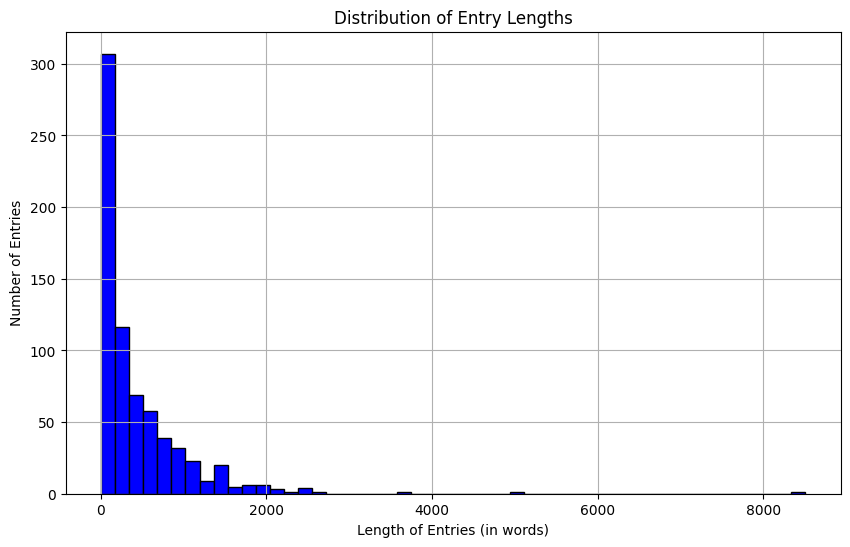

In [5]:
import matplotlib.pyplot as plt

# Calculate the length of each entry (in words)
df['entry_length'] = df['note'].apply(lambda x: len(x.split()))

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['entry_length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Entry Lengths')
plt.xlabel('Length of Entries (in words)')
plt.ylabel('Number of Entries')
plt.grid(True)
plt.show()

## 🕳️ Handle Empty Journal Entries

The min entry length is 0, which means entries with nothing in them.  
These serve no purpose, so let's get rid of them. 

In [6]:
# Filter empty entries
empty_entries = df[df['note'].str.len() == 0]

print("Number of empty entries:", len(empty_entries))

Number of empty entries: 34


### 🚮 Remove empty entries from the df

In [7]:
df = df[df['note'].str.len() > 0]

# Print empty entries again to make sure they are zero
empty_entries = df[df['note'].str.len() == 0]
print("Number of empty entries:", len(empty_entries))

Number of empty entries: 0


## 📏 Handle Very Short Entries

- Identify all entries with length less than `word_count_threshold`.  
- Entries of this length are a flag for data that may negatively influence the model's training.  

In [9]:
# Define the word count threshold
word_count_threshold = 15

# Filter the DataFrame to get entries with length less than the threshold
short_entries = df[df['entry_length'] < word_count_threshold]

# Display short entries
print("Number of short entries:", len(short_entries))
print(short_entries[short_entries.columns.difference(['entry_length'])][:10])

Number of short entries: 58
          date                                               note
23  2022-12-31           Far from a perfect year \nLeft me hungry
40  2020-12-17  HMU about 30 mins before hand. 9173927850 -Stefan
47  2022-05-01                   Damian Killa\n\nLast name: Killa
49  2021-08-14                           I wasn’t done being bad.
57  2022-07-16  I can’t stop being a whore!! I NEED this vacci...
65  2022-07-25  Between 3rd and Lexington\nCloser to third \n2...
90  2022-07-30  * Writing course\n* Exercise\n* Look at LA apa...
94  2022-04-15                                  You can do better
103 2022-06-18  Study for coding interviews\nGoogle UX design ...
110 2022-09-22  This is a message to myself that I am writing ...


- When I print the first ten short entries, I see that there are some that are meaningless and there are some that I want to keep. 
- I could delete them all but since there are only 58 of them, I will write a script to manually go through each and toss or keep.

### 🔎 Figure out which short entries to delete

In [11]:
# List to hold indexes of entries to delete
# Keep in separate cell to maintain its state
entries_ix_to_delete = []

In [12]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Display the journal entry for a given index
def show_entry_by_index(dataframe, index):
    if index in dataframe.index:
        entry = dataframe.loc[index]
        print(f"Index: {index}")
        print(f"Date: {entry['date']}")
        print("Note:")
        print(entry['note'])
    else:
        print(f"No entry found at index {index}")

def handle_entry_action(btn, ix, action):
    if action == 'delete':
        entries_ix_to_delete.append(ix)
        btn.description = 'Marked for Deletion'
    else:
        btn.description = 'Kept'
    
    # Disable both buttons to prevent further interaction
    for button in btn.container.children:
        button.disabled = True

for ix in short_entries.index.tolist():
    show_entry_by_index(df, ix)

    # Create a container for buttons
    button_container = widgets.HBox()
    
    # Create a delete button
    delete_btn = widgets.Button(description="Delete")
    delete_btn.container = button_container
    delete_btn.on_click(lambda btn, ix=ix: handle_entry_action(btn, ix, 'delete'))

    # Create a keep button
    keep_btn = widgets.Button(description="Keep")
    keep_btn.container = button_container
    keep_btn.on_click(lambda btn, ix=ix: handle_entry_action(btn, ix, 'keep'))

    # Add buttons to the container
    button_container.children = [delete_btn, keep_btn]
    
    display(button_container)

    # Separate the entries for readability
    print("\n" + "-"*40 + "\n")

Index: 23
Date: 2022-12-31 00:00:00
Note:
Far from a perfect year 
Left me hungry



----------------------------------------

Index: 40
Date: 2020-12-17 00:00:00
Note:
HMU about 30 mins before hand. 9173927850 -Stefan



----------------------------------------

Index: 47
Date: 2022-05-01 00:00:00
Note:
Damian Killa

Last name: Killa



----------------------------------------

Index: 49
Date: 2021-08-14 00:00:00
Note:
I wasn’t done being bad.



----------------------------------------

Index: 57
Date: 2022-07-16 00:00:00
Note:
I can’t stop being a whore!! I NEED this vaccine!!!



----------------------------------------

Index: 65
Date: 2022-07-25 00:00:00
Note:
Between 3rd and Lexington
Closer to third 
2nd floor

8am



----------------------------------------

Index: 90
Date: 2022-07-30 00:00:00
Note:
* Writing course
* Exercise
* Look at LA apartments



----------------------------------------

Index: 94
Date: 2022-04-15 00:00:00
Note:
You can do better



----------------------------------------

Index: 103
Date: 2022-06-18 00:00:00
Note:
Study for coding interviews
Google UX design course
Pinesbnb



----------------------------------------

Index: 110
Date: 2022-09-22 00:00:00
Note:
This is a message to myself that I am writing openly.



----------------------------------------

Index: 117
Date: 2020-01-01 00:00:00
Note:
Hey Johnny, y



----------------------------------------

Index: 130
Date: 2023-03-10 00:00:00
Note:
Sireina 

Like siren, the killers of the sea



----------------------------------------

Index: 132
Date: 2020-11-26 00:00:00
Note:
Chicken
Mashed potatoes
Asparagus
Gravy
Cranberry sauce



----------------------------------------

Index: 153
Date: 2023-03-23 00:00:00
Note:
Kara Swisher 😂



----------------------------------------

Index: 156
Date: 2022-05-18 00:00:00
Note:
18665385438



----------------------------------------

Index: 165
Date: 2021-12-03 00:00:00
Note:
https://www.airbnb.com/book/stays/21409981?numberOfAdults=1&numberOfChildren=0&numberOfInfants=0&checkin=2022-03-07&checkout=2022-03-14&guestCurrency=USD&productId=21409981&isWorkTrip=false&numberOfGuests=1&numberOfPets=0&code=HMP8B4QRZZ



----------------------------------------

Index: 169
Date: 2023-01-19 00:00:00
Note:
- Tops that don’t eat ass



----------------------------------------

Index: 171
Date: 2022-06-29 00:00:00
Note:
What food to get for lunch and dinner?
Eat
- Breakfast



----------------------------------------

Index: 174
Date: 2021-12-29 00:00:00
Note:
Hey, I don’t have a problem getting hard. It’s just that sometimes



----------------------------------------

Index: 183
Date: 2023-08-28 00:00:00
Note:
I love when the muse visits me



----------------------------------------

Index: 205
Date: 2023-04-14 00:00:00
Note:
Joe Cutaia talking about middle eastern men



----------------------------------------

Index: 219
Date: 2022-03-18 00:00:00
Note:
**# Auth**
**
**
https://www.pinesbnb.com/login?redirectRoute=%2Ftest%2Flanding&redirectAsPath=%2Ftest%2Flanding**
**
**
**



----------------------------------------

Index: 247
Date: 2022-12-13 00:00:00
Note:
https://open.spotify.com/episode/46nL3iby2igs0q69s8hCnq?si=vnfpg3uRRXOS-BuLC9WxMA

Role play how to negatively interact and then do the positive interaction



----------------------------------------

Index: 291
Date: 2022-03-27 00:00:00
Note:
Strapi



----------------------------------------

Index: 292
Date: 2022-06-28 00:00:00
Note:
Maya Pinion
Saline Cuisine 
Tanya Hardthing



----------------------------------------

Index: 293
Date: 2022-10-22 00:00:00
Note:
Build him up.



----------------------------------------

Index: 295
Date: 2021-08-08 00:00:00
Note:
There is no reading at the gay beach. Unless it’s other gays.



----------------------------------------

Index: 307
Date: 2020-12-26 00:00:00
Note:
Sitting in my bedroom alone for five days straight. Eating and sleeping schedule fucked.



----------------------------------------

Index: 315
Date: 2022-07-21 00:00:00
Note:
Dob
Ssn 
Address NY
Telephone 
Email address



----------------------------------------

Index: 318
Date: 2020-06-30 00:00:00
Note:
I spoke to



----------------------------------------

Index: 325
Date: 2019-11-18 00:00:00
Note:
His voice makes me want to cum and he has a beautiful mouth



----------------------------------------

Index: 336
Date: 2022-01-20 00:00:00
Note:
1. Osama
2. Ruggery
3. Disco dick
4. Brogan
5. Cameron Rose



----------------------------------------

Index: 342
Date: 2020-09-05 00:00:00
Note:
* Breakfast
* Cook chili
* Exercise
* Eat meals
* Write
* Greadee



----------------------------------------

Index: 356
Date: 2020-11-06 00:00:00
Note:
Raw exposures and portrayal of the world around me too

Burnerofbridges



----------------------------------------

Index: 365
Date: 2023-03-05 00:00:00
Note:
Every relationship I have ever been in has been interracial.



----------------------------------------

Index: 367
Date: 2022-02-13 00:00:00
Note:
Always build people up
That is how community is created



----------------------------------------

Index: 385
Date: 2022-09-17 00:00:00
Note:
115 1/2 N. Kings Road, Los Angeles CA



----------------------------------------

Index: 407
Date: 2021-01-30 00:00:00
Note:
Incredible thing



----------------------------------------

Index: 424
Date: 2019-08-21 00:00:00
Note:
Mowgli from the Jungle Book glowed up



----------------------------------------

Index: 433
Date: 2021-08-10 00:00:00
Note:
And all I need to do is catch it.



----------------------------------------

Index: 451
Date: 2022-02-24 00:00:00
Note:
We need better boundaries but we are ok.



----------------------------------------

Index: 474
Date: 2020-11-23 00:00:00
Note:
zlna-nsyj-bisc-xdql-rcgn



----------------------------------------

Index: 530
Date: 2022-03-12 00:00:00
Note:
866-7316393



----------------------------------------

Index: 534
Date: 2022-03-27 00:00:00
Note:
Image Engine.Oo



----------------------------------------

Index: 538
Date: 2020-09-14 00:00:00
Note:
Except to climb. I know how to climb. I was wired that way.



----------------------------------------

Index: 541
Date: 2022-02-07 00:00:00
Note:
*



----------------------------------------

Index: 543
Date: 2022-11-20 00:00:00
Note:
Bro, the bigger they are the harder they bottom.



----------------------------------------

Index: 567
Date: 2020-05-01 00:00:00
Note:
![2020-05-01-Money-](images/2020-05-01-Money-.png)



----------------------------------------

Index: 576
Date: 2020-05-26 00:00:00
Note:
Smile for you friends, cry later



----------------------------------------

Index: 578
Date: 2020-05-26 00:00:00
Note:
Why I’m exiting quarantine a little less gay



----------------------------------------

Index: 589
Date: 2022-09-20 00:00:00
Note:
Face wash
No poo deva curl



----------------------------------------

Index: 602
Date: 2020-05-30 00:00:00
Note:
Story of falling in love with your best friend



----------------------------------------

Index: 619
Date: 2020-10-29 00:00:00
Note:
145437 962172



----------------------------------------

Index: 620
Date: 2022-04-05 00:00:00
Note:
Atomoxetine - adhd
Vistaril - anxiety



----------------------------------------

Index: 627
Date: 2021-12-27 00:00:00
Note:
Horny, hung and human



----------------------------------------

Index: 668
Date: 2022-05-20 00:00:00
Note:
#gayfitness



----------------------------------------

Index: 690
Date: 2022-03-25 00:00:00
Note:
Mail gun



----------------------------------------

Index: 697
Date: 2022-08-08 00:00:00
Note:
I



----------------------------------------



In [15]:
print("Num short entries: ", len(short_entries))
print("Num short entries to delete: ", len(entries_ix_to_delete))

Num short entries:  58
Num short entries to delete:  42


### 🗑️ Delete unwanted short entries
- Iterated through each of the short entries and marked the useless ones for deletion.  
- Delete the entries marked for deletion from dataframe  

The indexes for short entries to delete ends up being:  
  
`[40, 47, 65, 90, 103, 110, 117, 130, 132, 153, 156, 165, 171, 174, 205, 219, 247, 291, 292, 315, 318, 336, 342, 356, 385, 407, 424, 433, 451, 474, 530, 534, 541, 567, 578, 589, 602, 619, 620, 668, 690, 697]`

In [16]:
print("Indexes to delete:", entries_ix_to_delete)
print("Number of entries to delete:", len(entries_ix_to_delete))
print("Number of entries in DataFrame before delete:", len(df))

# Remove the short entries listed in entries_ix_to_delete from the DataFrame
df = df.drop(entries_ix_to_delete)

# Reset the index if you want a continuous index after deletion
df.reset_index(drop=True, inplace=True)
print("Number of entries in DataFrame after delete:", len(df))

# Now df_dropped is your DataFrame with the specified entries removed

Indexes to delete: [40, 47, 65, 90, 103, 110, 117, 130, 132, 153, 156, 165, 171, 174, 205, 219, 247, 291, 292, 315, 318, 336, 342, 356, 385, 407, 424, 433, 451, 474, 530, 534, 541, 567, 578, 589, 602, 619, 620, 668, 690, 697]
Number of entries to delete: 42
Number of entries in DataFrame before delete: 668
Number of entries in DataFrame after delete: 626


## 🐍 Handle Very Long Entries

Determine the threshold for long entries. 

🤔 When to use word count vs. tokenization?
- It's okay to use word count for the initial step of identifying very long entries.
- However, when it comes to processing these entries (segmentation, preparation for training), tokenization should be used to align with the model's processing capabilities and constraints.

count     626.000000
mean      484.392971
std       627.400148
min         3.000000
25%        97.000000
50%       281.500000
75%       663.000000
max      8508.000000
Name: word_count, dtype: float64
Proposed threshold for very long entries: 1512.75 words


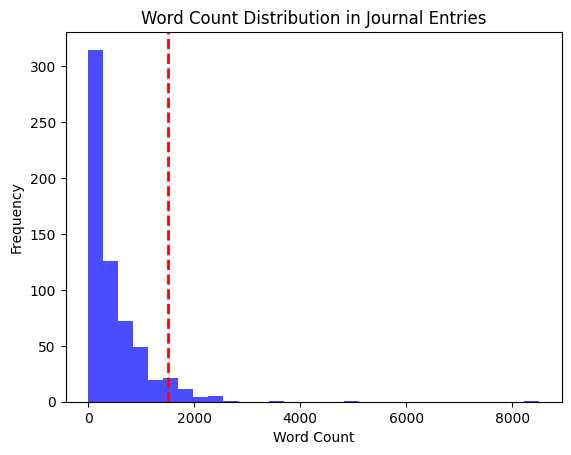

Number of very long entries: 32


In [17]:
import matplotlib.pyplot as plt

# Calculate word count for each entry
df['word_count'] = df['note'].apply(lambda x: len(str(x).split()))

# Descriptive statistics to understand the distribution
print(df['word_count'].describe())

# Identify a potential threshold for long entries, e.g., using the 95th percentile
threshold = df['word_count'].quantile(0.95)
print(f"Proposed threshold for very long entries: {threshold} words")

# Plotting a histogram for visual analysis
plt.hist(df['word_count'], bins=30, color='blue', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)
plt.title('Word Count Distribution in Journal Entries')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Filtering the DataFrame for very long entries
long_entries_df = df[df['word_count'] > threshold]
print(f"Number of very long entries: {len(long_entries_df)}")

### ✂️ Identify Split Points Using spaCy

💡 Now it is time to use tokenization!  

- We have identified the long entries based on a word count threshold.  
- Long entries need to be split up into smaller entries
- Use NLP tool spaCy to identify logical split points in the entries

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

import spacy
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

In [60]:
def segment_entry(entry, max_token_length=512):
    """
    Segments a long journal entry into smaller parts based on token count and natural sentence boundaries.

    Args:
    entry (str): The journal entry to be segmented.
    max_token_length (int): The maximum token length for each segment.

    Returns:
    List[str]: A list of segmented journal entries.
    """
    doc = nlp(entry)
    segments = []
    current_tokens = []

    for sent in doc.sents:
        # Tokenize the sentence
        sentence_tokens = tokenizer.tokenize(sent.text)
        
        if len(current_tokens) + len(sentence_tokens) > max_token_length:
            # Convert current segment to text and store it
            segment_text = tokenizer.convert_tokens_to_string(current_tokens)
            segments.append(segment_text.strip())
            current_tokens = sentence_tokens
        else:
            current_tokens.extend(sentence_tokens)

    # Add the last segment if not empty and not a duplicate
    if current_tokens:
        segment_text = tokenizer.convert_tokens_to_string(current_tokens).strip()
        if not segments or (segments and segments[-1] != segment_text):
            segments.append(segment_text)

    return segments


Test `segment_entry` out on an entry

In [61]:
# Example of a long entry
first_entry = long_entries_df.iloc[0]['note']
print(first_entry)

I did not wake up at 6:30 as my alarm clock intended however I was lights out and in bed at 10:30. Unfortunately I was arguing with Josh in my head until midnight. I ended up having an incredible day. I woke up rested, I wrote a shit ton, went on a thirty minute walk and thought good thoughts. 

Worked on my second brain. 
Came to some good conclusions. 
One of which I started writing about yesterday. 
Stop giving so many fucks! 
My whole world was Jason and Josh and it consumed me. 
Going to George’s pool party reminded me of all the connections there are to be made out there. 
All the wonderful people. 
There is a whole world out there fay beyond our little exclusive friend group. 
Far beyond LA. 
A whole great, big world with all kinds of adventures and explorations. 

I was sitting in the backyard yesterday when josh and Jason came home. 
Josh came to the back door and we had a little exchange. 
I complimented his shorts. He told me where he got them. 
“Cute” I remarked. 

Jason wa

In [62]:
segments = segment_entry(first_entry)
# Display the segments
for i, segment in enumerate(segments, 1):
    print(f"🍊 Segment {i}:\n{segment}\n\n")

🍊 Segment 1:
I did not wake up at 6:30 as my alarm clock intended however I was lights out and in bed at 10:30. Unfortunately I was arguing with Josh in my head until midnight. I ended up having an incredible day. I woke up rested, I wrote a shit ton, went on a thirty minute walk and thought good thoughts. 

 Worked on my second brain. 
 Came to some good conclusions. 
 One of which I started writing about yesterday. 
 Stop giving so many fucks! 
 My whole world was Jason and Josh and it consumed me. 
 Going to George’s pool party reminded me of all the connections there are to be made out there. 
 All the wonderful people. 
 There is a whole world out there fay beyond our little exclusive friend group. 
 Far beyond LA. 
 A whole great, big world with all kinds of adventures and explorations. 

 I was sitting in the backyard yesterday when josh and Jason came home. 
 Josh came to the back door and we had a little exchange. 
 I complimented his shorts. He told me where he got them. 
 “C

### 🔧 Apply Segmentation to Long Entries

In [63]:

# Apply segmentation to each 'note' in long_entries_df
# Create a new column 'segments' with the applied segmentation
segmented_series = long_entries_df['note'].apply(segment_entry)
long_entries_df = long_entries_df.assign(segments=segmented_series)

# Now, long_entries_df has a new column 'segments' containing the segmented entries
long_entries_df.head()

,date,note,entry_length,word_count,segments
4,2023-04-10,I did not wake up at 6:30 as my alarm clock in...,1687,1687,[I did not wake up at 6:30 as my alarm clock i...
14,2021-09-27,Letting myself be happy\nWas key\nTo invite in...,1794,1794,[Letting myself be happy\nWas key\nTo invite i...
23,2021-05-18,And I know that it will get what it want if it...,2169,2169,[And I know that it will get what it want if i...
39,2023-03-01,I’m doing my best. And my best begins with bei...,1728,1728,[I’m doing my best. And my best begins with be...
41,2022-08-21,"I’m in Austin, TX visiting Jamie. Was supposed...",2451,2451,"[I’m in Austin, TX visiting Jamie. Was suppose..."


### 🖇️ Integrate Segments Into Training Data

🥞 **Flatten the Segmented Data**  
  
Since `long_entries_df['segments']` now contains lists of segments, flatten these lists so that each segment becomes a separate row in a new DataFrame.  

In [67]:
# Flatten the DataFrame
flattened_df = pd.DataFrame([(date, segment) 
                             for date, segments in zip(long_entries_df['date'], long_entries_df['segments'])
                             for segment in segments], 
                            columns=['date', 'note'])

# Display the new DataFrame structure
print(flattened_df.head())

        date                                               note
0 2023-04-10  I did not wake up at 6:30 as my alarm clock in...
1 2023-04-10  I almost got there. \n I dipped my toe in the ...
2 2023-04-10  I was silent for most of the ride and staring ...
3 2023-04-10  **Find every fuck you give and set them free. ...
4 2023-04-10  In the wake of what I thought was the collapse...


🔗 **Combine Segmented Data with Original DataFrame**  
  
Once you have the flattened DataFrame of segments, combine it with the original data.  

Drop the original long entries from df  

In [68]:
# Drop the original long entries from the original DataFrame
df_shortened = df.drop(long_entries_df.index)

# Before concatenating, make sure the columns in flattened_df and df_shortened align
# They should both have the same columns, e.g., 'date' and 'note'
print("Columns in df_shortened:", df_shortened.columns)
print("Columns in flattened_df:", flattened_df.columns)

Columns in df_shortened: Index(['date', 'note', 'entry_length', 'word_count'], dtype='object')
Columns in flattened_df: Index(['date', 'note'], dtype='object')


**🐞 Fix  Duplicate Entries Bug**
- Drop extra columns in `df_shortened`  
- `entry_length` and `word_count` are not required in the final combined DF
- They were causing problems when concatenating the df with the flattened segments DF

In [69]:
# Drop unnecessary columns so that df_shortened and flattened_df have the same columns and can be concatenated
df_shortened = df_shortened[['date', 'note']]

✅ Validate that columns are the same

In [73]:
print("Columns in df_shortened:", df_shortened.columns)
print("Columns in flattened_df:", flattened_df.columns)

# Ensure that both DataFrames have the same columns for concatenation
assert set(df_shortened.columns) == set(flattened_df.columns), "Columns do not match in DataFrames"

Columns in df_shortened: Index(['date', 'note'], dtype='object')
Columns in flattened_df: Index(['date', 'note'], dtype='object')


In [74]:
# Concatenate the flattened segmented data with the shortened original DataFrame
combined_df = pd.concat([df_shortened, flattened_df], ignore_index=True)

# Display the structure of the combined DataFrame
print(combined_df.head())
print("\n Length: ", len(combined_df))

        date                                               note
0 2021-12-30  A porn addiction\nPoor performance at work\nNo...
1 2022-03-27  You raped my childhood if any innocence it eve...
2 2024-01-07  I have to admite something. Although i am sad ...
3 2023-03-02  I was going to do the Write of Passage course ...
4 2022-05-12  So it begins with a spiral about continuing wi...

 Length:  794


In [76]:
duplicates = combined_df[combined_df.duplicated(subset=['note'], keep=False)]
print(duplicates)

          date                                               note
199 2022-11-23  I’m on the plane without wifi and I just spill...
534 2022-11-23  I’m on the plane without wifi and I just spill...


😤 There is one duplicate left. I don't know why but let's drop it.

In [77]:
unique_df = combined_df.drop_duplicates()

duplicates = unique_df[unique_df.duplicated(subset=['note'], keep=False)]
print(duplicates)

Empty DataFrame
Columns: [date, note]
Index: []


In [78]:
unique_df.__len__()

793

Cool, no more duplicates.

✅ Validate that the integration worked

In [79]:
# Validate shapes
print("Original DF shape:", df.shape)
print("Shortened DF shape:", df_shortened.shape)
print("Flattened DF shape:", flattened_df.shape)
print("Combined DF shape:", combined_df.shape)

# Ensure the number of rows is as expected
assert combined_df.shape[0] == df_shortened.shape[0] + flattened_df.shape[0]

# Inspect head and tail
print(combined_df.head())
print(combined_df.tail())

# Random sampling
print(combined_df.sample(5))

# Check for duplicates (assuming 'note' column for journal entries)
assert not combined_df.duplicated(subset=['note']).any()

# Check data types
print(combined_df.dtypes)

Original DF shape: (626, 4)
Shortened DF shape: (594, 2)
Flattened DF shape: (200, 2)
Combined DF shape: (794, 2)
        date                                               note
0 2021-12-30  A porn addiction\nPoor performance at work\nNo...
1 2022-03-27  You raped my childhood if any innocence it eve...
2 2024-01-07  I have to admite something. Although i am sad ...
3 2023-03-02  I was going to do the Write of Passage course ...
4 2022-05-12  So it begins with a spiral about continuing wi...
          date                                               note
789 2021-06-06  Trey does not exist anymore and neither do any...
790 2021-06-06  And when you do nut, I can feel that dick puls...
791 2021-06-06  I didn’t know if I wa crying because of the pa...
792 2021-06-06  I smile to myself and cut mine into pieces and...
793 2021-06-06  If he touches me I will crack open like a waln...
          date                                               note
376 2022-04-24  Another weekend morning 

AssertionError: 

📝 **Prepare for Training**  
  
After integrating the segmented data, the next step is to prepare the data for training. 
This includes any additional preprocessing steps like tokenization and formatting the data as required by your model.

In [82]:
# Use this DF for training and going forward since it represents the final preprocessed data
final_df = combined_df[['date', 'note']]

# ✒️ Formatter Function

A function to structure training examples as prompts.

In [93]:
def formatting_func(row):
    # I'm keeping Eevee the Dog bc it's cute and I couldn't think of anything better
    formatted_text = f"### Date: {row['date']} \n### Note by Eevee the Dog: {row['note']}"
    return formatted_text

### 🤔 Why did we choose this formatter func?
I found the choice to use this formatter function interesting. It opened my eyes to the significance of properly formatting prompts for effective model training. This formatter in particular allows us to train the model only on inputs (the journal entries) without the need for output targets. If we were going for Q&A dialogue format, we would have gone with something like this: 

```python
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text
```

### 🍀 Benefits of Formatter Function

**🕊️ Simplifies Data Preparation**  
- No need for explicit output targets simplifies dataset preparation.
- Focus is solely on formatting inputs (journal entries) correctly.

**🤸‍♀️ Flexibility in Model Use**  
- Training with input-only (journal entries) enhances model's understanding of style, tone, and content.
- Post-training, the model can:
  - Generate content similar to the training data.
  - Answer questions related to the content.
  - Continue a journal entry in a consistent style.

**💪🏽 Leverages Internal Model Capabilities**  
- Utilizes the pre-training of advanced language models on extensive text data.
- Fine-tunes model's inherent language and structure understanding.
- Aligns model capabilities with the specific style and content of journal entries without needing output targets.

### 🔮 Invoke Eevee the Dog with Prompting

The model can be prompted for inference in any of the following ways:

1. **Variations of the Header**
You can use variations of the original header that maintain the essence but change the phrasing. For example:  
    - "Eevee the Dog wrote the following note:"
    - "Note by Eevee the Dog:"

  
2. **Contextual or Thematic Prompts**
If the journal entries are themed or contextualized, you can prompt the model using these themes or contexts. For instance:
    - "Reflecting on a day in the park, Eevee the Dog noted:"
    - "In a mood of contemplation, Eevee the Dog wrote:"


3. **Direct Questions or Statements**
You can also use direct questions or statements related to the content of the journals. For example:
    - "What did Eevee the Dog say about his adventures today?"
    - "Describe a recent experience of Eevee the Dog."


4. **Using Keywords or Topics**
Prompt the model with specific keywords or topics that are prevalent in the journal entries. For example:
    - "Discuss Eevee the Dog's thoughts on happiness."
    - "Eevee the Dog's perspective on friendship:"
  

5. **Narrative or Storytelling Starters**
Engage the model with a narrative starter that aligns with the style of the journal entries. For example:
    - "Once upon a time, Eevee the Dog felt..."

# 🔀 Split data into training, validation and test sets

In [117]:
from sklearn.model_selection import train_test_split

# Keep the val set small because we have a small dataset
# 10% of the data will be in the test set
val_size = 0.1  

train_df, val_df = train_test_split(final_df, test_size=val_size, random_state=42)

# 🔠 Tokenize the Dataset

In [107]:
def generate_and_tokenize_row(row):
    return tokenizer(formatting_func(row))

### ✒️ Apply formatting function

In [118]:
# Apply the formatting function to each row
train_df['formatted_note'] = train_df.apply(formatting_func, axis=1)
val_df['formatted_note'] = val_df.apply(formatting_func, axis=1)

### 📐 Determine `max_length` for training inputs

In [119]:
tokenized_col = "tokenized_data"

# Apply the formatting function to each row
train_df[tokenized_col] = train_df.apply(generate_and_tokenize_row, axis=1)
val_df[tokenized_col] = val_df.apply(generate_and_tokenize_row, axis=1)

Get a distribution of the dataset lengths, so the appropriate max_length for input tensors can be determined.

794


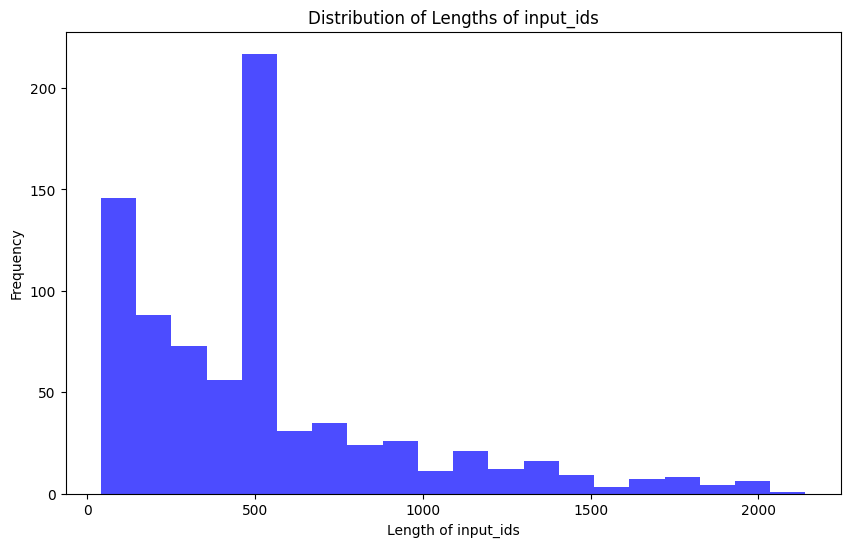

In [120]:
import matplotlib.pyplot as plt

def plot_data_lengths(train_df, val_df):
    # Extract the lengths of tokenized notes
    train_lengths = train_df[tokenized_col].apply(lambda x: len(x['input_ids']))
    val_lengths = val_df[tokenized_col].apply(lambda x: len(x['input_ids']))
    lengths = train_lengths.tolist() + val_lengths.tolist()
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(train_df, val_df)

**📦 All entries fit within the model's context** 

Most entries being within the 500-token range, and even the largest around 2000 tokens, fit comfortably within the model's context limit of 16k tokens. This means that truncation for context limit reasons may not be necessary.  

**💾 Memory useage considerations**  

Longer inputs require more memory and computational power, which could impact the training time, especially on GPUs with limited memory like the A10G.

**⚖️ Balancing Length and Efficiency**

The spike at 500 tokens and a significant number of entries with fewer tokens suggest a trade-off. You could potentially reduce the max_length to lower memory usage and accelerate training, but this might lead to losing some context from the longer entries.


### 🌕 Set `max_length`

I set `max_length` to 1500 because I want the model to be trained on longer entries to make it as "natural" as possible when it comes to what my journal entries are like and am ok with potentially having to upgrade to an A100 instance. 

In [112]:
max_length = 1500

### 🪓 Tokenize and Truncate the Dataset

In [114]:
def tokenize_and_truncate(row):
    formatted_note = formatting_func(row)
    result = tokenizer(
        formatted_note,
        truncation=True,
        max_length=max_length,
        padding="max_length",
        return_tensors="pt"  # Add this if you are using PyTorch and need tensors
    )
    # Copy input_ids to labels for language model training, ensuring separate memory allocation with clone()
    result["labels"] = result["input_ids"].clone()  # Use clone() for PyTorch tensors
    return result

In [121]:
# Apply to the dataframes
train_df[tokenized_col] = train_df.apply(tokenize_and_truncate, axis=1)
val_df[tokenized_col] = val_df.apply(tokenize_and_truncate, axis=1)

794


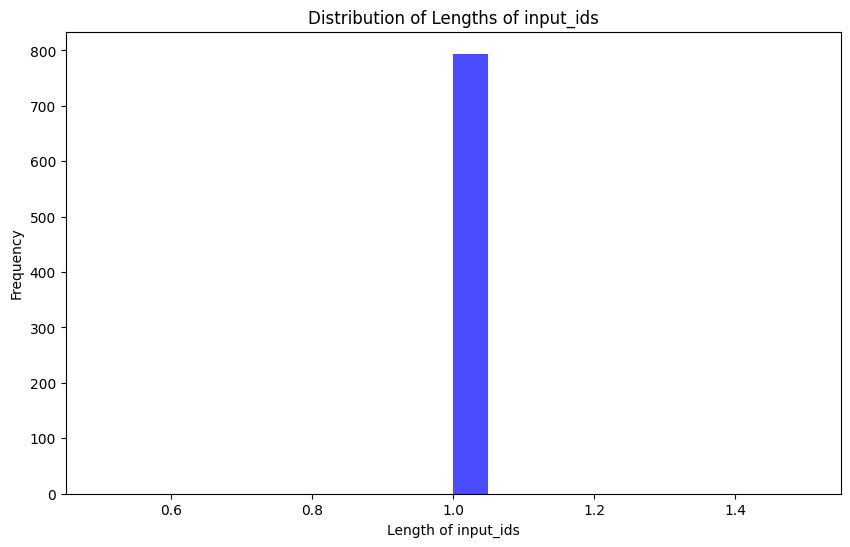

In [122]:
plot_data_lengths(train_df, val_df)

Now all samples are the same length.  

Uniform sample length is crucial for batch processing in neural networks, ensuring consistent input shape across all data, which is a requirement for most deep learning models.

# 💯 Evaluate base model before training

In [123]:
eval_prompt = " The following is a note by Eevee the Dog: # "

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

# ⚙️ Set up LoRA for Fine-Tuning an LLM


## 🧘🏽‍♀️ Prepare Model for Training

Using prepare_model_for_kbit_training from the PEFT library prepares the model for efficient training, enabling gradient checkpointing to save memory.

In [124]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

NameError: name 'model' is not defined

## 🔎 Examine Layers

Printing the model structure helps identify layers to apply LoRA, like q_proj, k_proj, etc.

In [126]:
print(model)

NameError: name 'model' is not defined

## 🛠️ Configure LoRA

LoRA (Low-Rank Adaptation) is a technique to fine-tune large models efficiently by updating only a small subset of model parameters.

### 🔧 Configuration
`r` (Rank)  
Determines the size of low-rank matrices. Affects the number of trainable parameters.

`lora_alpha`  
Scaling factor for LoRA weights.

`target_modules`  
Specific layers where LoRA is applied

Target modules are determined by examining the model's architecture and identifying layers that significantly influence its predictions

### 💎 Chosen Values
`r (Rank) = 32`  
`lora_alpha = 64`  

The chosen values aim for a balance between model expressivity and computational complexity.

In [127]:
from peft import LoraConfig, get_peft_model

# LoRA configuration
config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj", "lm_head"],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

# Apply LoRA to the model
model = get_peft_model(model, config)

NameError: name 'model' is not defined

## 🔌  Add LoRA Adapters
LoRA adapters are added to specified layers using `get_peft_model` + the LoRA configuration.


In [128]:
from peft import get_peft_model

# Apply LoRA to the model using the specified LoRA configuration
model = get_peft_model(model, config)

NameError: name 'model' is not defined

## 🏋🏽‍♂️ Check Trainable Parameters
A function prints the number of trainable parameters, showing a small percentage of the total, indicating efficiency.


In [125]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

## 👀 View Modified Model
Finally, printing the model shows the changes made, with LoRA adapters added.

In [130]:
print(model)

NameError: name 'model' is not defined

# 🦾 Fine-Tune the Model with LoRA 

## 👁️ Training Scope

**Know the number of data samples in train and val datasets helps us to:**

- Ensure there's sufficient data for effective model training
- Gauge the potential for overfitting
- Guide decisions on training configuration such as batch size and number of epochs


In [138]:
train_size = len(train_df)
val_size = len(val_df)

print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")
print(f"\nTotal dataset size: {train_size + val_size} 🎉")

Training dataset size: 714
Validation dataset size: 80

Total dataset size: 794 🎉


### 🧪 Ensure Sufficient Data for Effective Training

- With 714 samples, you likely have enough data to fine-tune a pre-trained model, especially if it's a language model already familiar with the general structure of language.

- If your data is highly specialized, consider data augmentation or transfer learning techniques to maximize learning from available data.

### 🎯 Gauge the Potential for Overfitting

- Overfitting is a risk when the model learns the training data too well, failing to generalize.

- Regularly evaluate performance on the validation set (80 samples) to monitor for overfitting. If validation performance begins to worsen while training performance improves, it's a sign of overfitting.

- Implement strategies like dropout or early stopping if overfitting is observed.

### 🧭 Guide Decisions on Training Configuration

🍪 **Batch Size**  

Choose a batch size that balances learning efficiency and computational constraints. With 714 samples, a smaller batch size (e.g., 16 or 32) can be effective.

🔁 **Number of Epochs**  

Decide on the number of epochs based on the model's learning rate and the complexity of the task. Start with a moderate number (e.g., 3-5 epochs) and adjust based on training and validation performance.

📈 **Learning Rate**  

A smaller learning rate is often preferred for fine-tuning to make subtle adjustments to the pre-trained model.

🏁 **Regular Checkpoints**  

Save model checkpoints regularly to avoid losing progress and to allow for model evaluation at different stages of training.

## 💻 Training Setup

Multi-GPU support if available

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

Using the **`Trainer`** class from Hugging Face Transformers

Setting training arguments like batch size, learning rate, logging, and saving strategies